In [1]:
#!pip install trafilatura

In [2]:
import os

import numpy as np
import pandas as pd

from lxml import html
from bs4 import BeautifulSoup
import trafilatura

In [3]:
#!npx degit kelu124/substack/.archive substack --force

In [4]:
files = os.listdir('.archive')
file_names = []
for name in files:
    if not ('type' in name):
        file_names.append(name)

In [5]:
import io

In [6]:
articles = []
errors = []
for file_name in file_names:
    with io.open(f'.archive/{file_name}', mode="r", encoding="utf-8") as f:
        try:
            mytree = html.fromstring("".join(f.readlines()))
        except Exception as e:
            print(e)
            errors.append(file_name)
            continue
        try:
            content = trafilatura.extract(mytree)
            articles.append((file_name, content))
        except Exception as e:
            print(e)
            errors.append(file_name)

'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xe2 in position 10: invalid continuation byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xe2 in position 10: invalid continuation byte
Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
'utf-8' codec can't decode byte 0x8f in position 10: invalid start byte
'utf-8' c

In [7]:
len(articles)

1088

In [9]:
df = pd.DataFrame(articles, columns = ['file_name', 'content'])
df["LEN"] = df["content"].apply(lambda x: len(str(x)))

In [10]:
df.to_parquet('articles.parquet.gzip',compression="gzip")

In [11]:
# More testing here about the coherent text that has to be found, find upper elements if p doesn't mention classes. 
# or merge everything than clean up.


In [12]:
df = pd.read_parquet('articles.parquet.gzip')
df

,file_name,content,LEN
0,ea74b217d36ec570bb432fb5aa679090,The first place that AI panic hit was classroo...,12440
1,eed4c324ed72bb2a93853837097c6d24,Veuillez mettre à jour votre navigateur\nVotre...,373
2,58c165e1a46408307f2b60f63df7c549,Plant-inspired E-seeds drill themselves into t...,2345
3,3938700a79bbde32972657f9eb7b1b69,Well-being of Future Generations (Wales) Act 2...,3351
4,877086f84693df653217bc659254b119,"My kids are 19, 17, 12. I tell them- you're no...",51420
...,...,...,...
1083,3fbb11d6e949d1e662aa6a146bb6cda0,China’s growing number of insomniacs are turni...,2859
1084,e8b7faf708568f9f39abe04b778c4631,I would say my efficiency is up ~20% since sta...,14337
1085,d89d7cc690ceaaafaecc9f40ff8230c5,My kids and I just played D&D with ChatGPT4 as...,34489
1086,69637dcd83c48ebde0610a61a27b1989,The newest Kindle is the first truly new Kindl...,6249


In [13]:
# Removing unaccessible articles
df = df[~(df['content'] == "Please switch to a supported browser to continue using twitter.com. You can see a list of supported browsers in our Help Center.\nHelp Center\nTerms of Service\nPrivacy Policy\nCookie Policy\nImprint\nAds info\n© 2022 Twitter, Inc.")]
df = df[df.LEN >= 1500]
df

,file_name,content,LEN
0,ea74b217d36ec570bb432fb5aa679090,The first place that AI panic hit was classroo...,12440
2,58c165e1a46408307f2b60f63df7c549,Plant-inspired E-seeds drill themselves into t...,2345
3,3938700a79bbde32972657f9eb7b1b69,Well-being of Future Generations (Wales) Act 2...,3351
4,877086f84693df653217bc659254b119,"My kids are 19, 17, 12. I tell them- you're no...",51420
5,997c962feb825d066ca4dc6e4742e8a9,Review of “Power and Progress: Our Thousand-Ye...,7390
...,...,...,...
1082,edbb7336dfb26098bcc966ca17c074b9,It was time to consider calling it a night. Sh...,15656
1083,3fbb11d6e949d1e662aa6a146bb6cda0,China’s growing number of insomniacs are turni...,2859
1084,e8b7faf708568f9f39abe04b778c4631,I would say my efficiency is up ~20% since sta...,14337
1085,d89d7cc690ceaaafaecc9f40ff8230c5,My kids and I just played D&D with ChatGPT4 as...,34489


In [14]:
df.describe()

,LEN
count,841.000000
mean,12320.003567
std,22891.540965
min,1505.000000
25%,3999.000000
50%,6998.000000
75%,13408.000000
max,496896.000000


In [15]:
# TF-IDF Feature Generation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# # Vectorize document using TF-IDF
tf_idf_vect = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,2),
                        tokenizer = tokenizer.tokenize)

# Fit and Transfrom Text Data
X_train_counts = tf_idf_vect.fit_transform(df['content'])

# Check Shape of Count Vector
X_train_counts.shape

(841, 773887)

In [16]:
X_train_counts[0]

<1x773887 sparse matrix of type '<class 'numpy.float64'>'
	with 1593 stored elements in Compressed Sparse Row format>

In [17]:
from sklearn.cluster import KMeans

# Create Kmeans object and fit it to the training data 
kmeans = KMeans(n_clusters=10).fit(X_train_counts)

# Get the labels using KMeans
pred_labels = kmeans.labels_

In [18]:
# Import WordCloud and STOPWORDS
from wordcloud import WordCloud
from wordcloud import STOPWORDS
# Import matplotlib
import matplotlib.pyplot as plt 


def word_cloud(text,wc_title,wc_file_name='wordcloud.jpeg'):
    # Create stopword list
    stopword_list = set(STOPWORDS) 

    # Create WordCloud 
    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopword_list, 
                           min_font_size = 14).generate(text) 

    # Set wordcloud figure size
    plt.figure(figsize = (8, 6)) 
    
    # Set title for word cloud
    plt.title(wc_title)
    
    # Show image
    plt.imshow(word_cloud) 

    # Remove Axis
    plt.axis("off")  

    # save word cloud
    # plt.savefig(wc_file_name,bbox_inches='tight')

    # show plot
    plt.show()

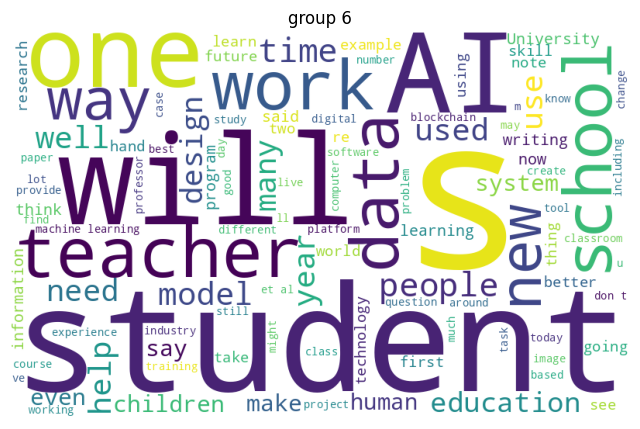

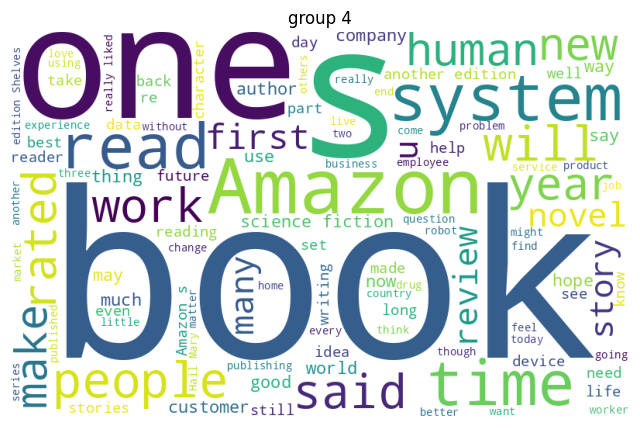

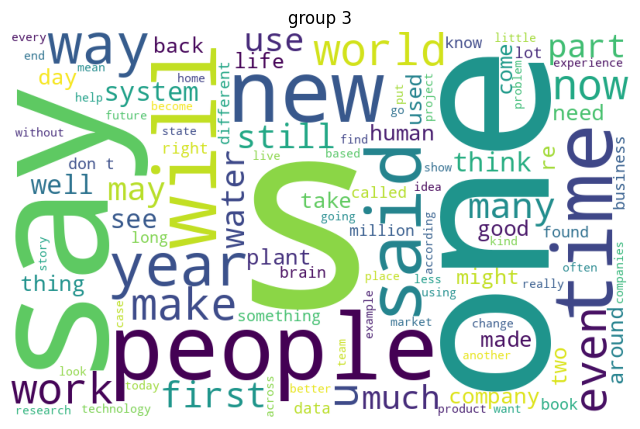

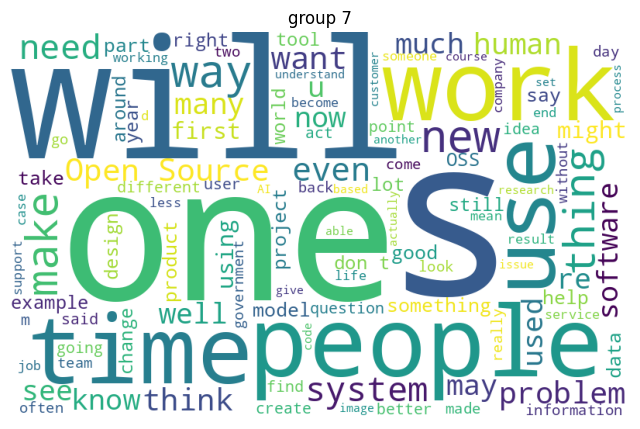

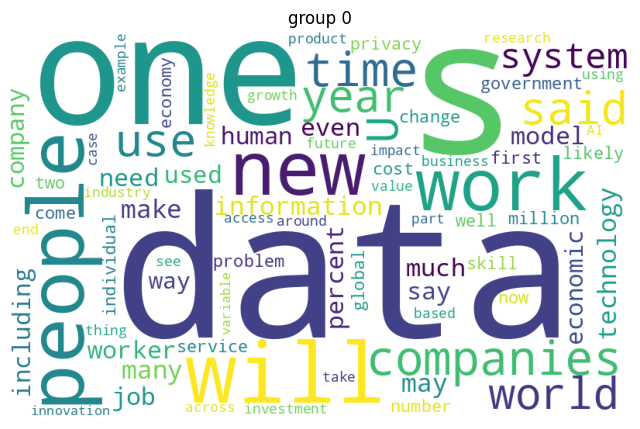

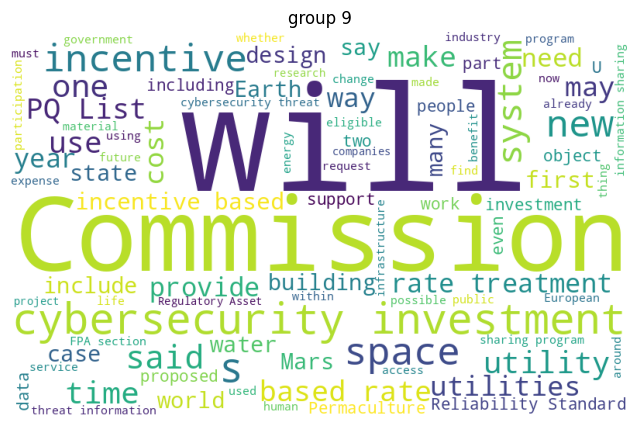

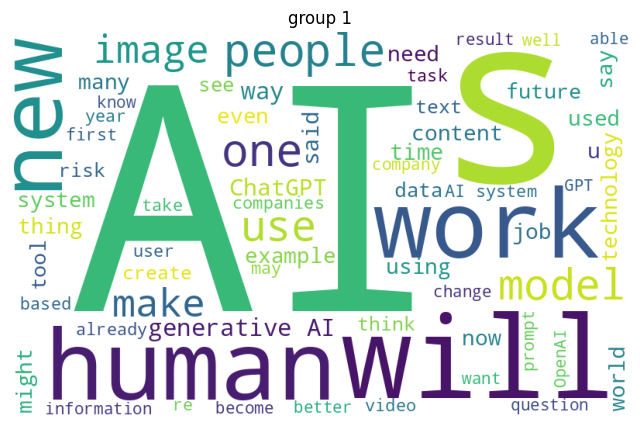

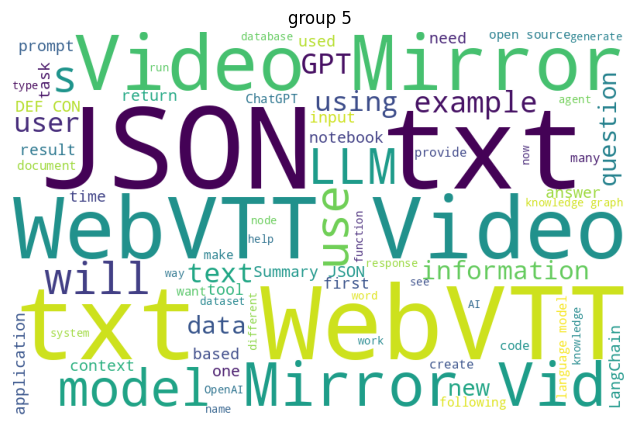

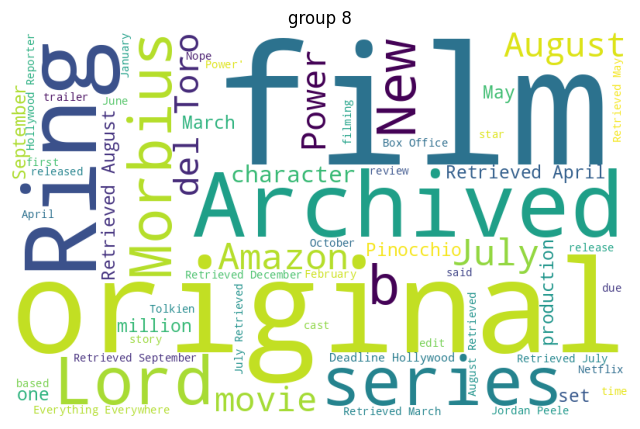

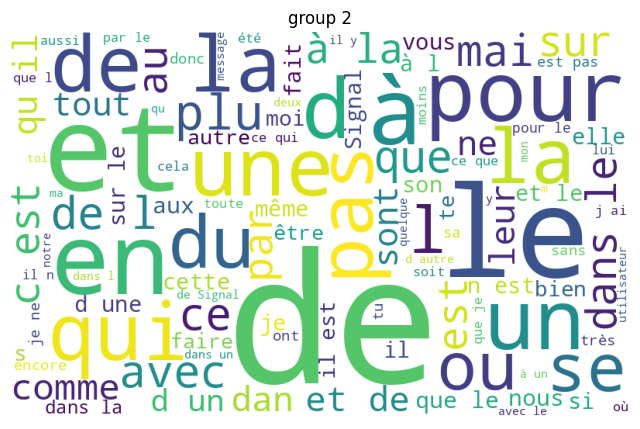

In [19]:
import pandas as pd
new_df=pd.DataFrame({"text":df['content'],"labels":pred_labels})


for i in new_df.labels.unique():
    new_new_df=new_df[new_df.labels==i]
    text="".join(new_new_df.text.tolist())
    word_cloud(text,f"group {i}",f'{i}.jpeg')

In [20]:
# new_df includes the category for errord ones as well.
# No context is given, so the group name is default to the group number.
# We can use the common words found in each group to formulate a title?
new_df.to_csv('grouped_articles.csv')

In [21]:
new_df

,text,labels
0,The first place that AI panic hit was classroo...,6
2,Plant-inspired E-seeds drill themselves into t...,4
3,Well-being of Future Generations (Wales) Act 2...,3
4,"My kids are 19, 17, 12. I tell them- you're no...",7
5,Review of “Power and Progress: Our Thousand-Ye...,0
...,...,...
1082,It was time to consider calling it a night. Sh...,7
1083,China’s growing number of insomniacs are turni...,3
1084,I would say my efficiency is up ~20% since sta...,7
1085,My kids and I just played D&D with ChatGPT4 as...,7
